In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt # Visualization
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

test.csv
train.csv



In [46]:
# Load Data
train_raw = pd.read_csv("../input/train.csv")
test_raw = pd.read_csv("../input/test.csv")
print("Data Loaded")

Data Loaded


In [47]:
def get_features(raw_data):
    cols = []
    # Get data of each row from pixel0 to pixel783 
    for px in range(784):
        cols.append("pixel"+str(px))   
    return raw_data.as_matrix(cols)/255

def cross_validated(X, n_samples):
    kf = KFold(n_samples, shuffle = True)
    result = [group for group in kf.split(X)]
    return result        

In [48]:
# Deep Implementation 
# Initialize Parameters 
def init_dnn_parameters(n, activations, epsilons, filter=None):
    L = len(n)
    params = {}
    for l in range(1,L):
        W = np.random.randn(n[l],n[l-1]) * epsilons[l] 
        # Experiment, multiply filter in case of input layer weights 
        if filter1 is not None and l == 1:
            W = np.dot(W, filter) 
        b = np.zeros((n[l],1))
        params["W"+str(l)] = W
        #print(" initizlizing W"+str(l))
        params["b"+str(l)] = b                        
        params["act"+str(l)] = activations[l]
    params["n"] = n
    return params

# Activation Functions 
def gdnn(X, activation_function):
    leak_factor = 1/10000
    if activation_function == 'tanh':
        return np.tanh(X)
    if activation_function == 'lReLU':
        return ((X > 0) * X) + ((X <= 0)* X * leak_factor)
    else: 
        return 1 / (1 +np.exp(-X))

def gdnn_prime(X, activation_function):
    leak_factor = 1/10000
    if activation_function == 'tanh':
        return 1-np.power(X,2)
    if activation_function == 'lReLU':
        return ((X > 0) * 1) + ((X <= 0)* leak_factor)
    else: 
        return (1 / (1 +np.exp(-X)))*(1-(1 / (1 +np.exp(-X))))

# Cost 
def get_dnn_cost(Y_hat, Y):
    #print(Y.shape)
    m = Y.shape[1]
    logprobs = np.multiply(np.log(Y_hat),Y) + np.multiply(np.log(1-Y_hat),1-Y)
    cost = - np.sum(logprobs) /m
    return cost
    
# Forward Propagation 
def forward_dnn_propagation(X, params):
    # Get Network Parameters 
    n = params["n"]
    L = len(n)
    
    A_prev = X
    cache = {}
    cache["A"+str(0)] = X
    for l in range(1,L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        Z = np.dot(W,A_prev)+b
        A = gdnn(Z,params['act'+str(l)])
        cache["Z"+str(l)] = Z
        cache["A"+str(l)] = A
        
        A_prev = A
    return A, cache 

# Backward Propagation
def back_dnn_propagation(X, Y, params, cache, alpha = 0.01, _lambda=0, keep_prob=1):
    n = params["n"]
    L = len(n) -1
    
    m = X.shape[1]
    W_limit = 5
    A = cache["A"+str(L)]
    A1 = cache["A"+str(L-1)]
    #print("back_dnn_propagation: A(L) shape"+str(A.shape))
    #print("back_dnn_propagation: A1(L) shape"+str(A1.shape))
    grads = {}
    
    # Outer Layer 
    dZ = A - Y#gdnn_prime(A - Y, params["act"+str(L)])
    #print("back_dnn_propagation: dZ(L) shape"+str(dZ.shape))
    dW = 1/m * np.dot(dZ, A1.T)
    #print("back_dnn_propagation: dW(L) shape"+str(dW.shape))
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    grads["dZ"+str(L)] = dZ
    grads["dW"+str(L)] = dW + _lambda/m * params["W"+str(L)]
    grads["db"+str(L)] = db
    
    # Update Outer Layer
    params["W"+str(L)] -= alpha * dW
    #params["W"+str(L)] = np.clip(params["W"+str(L)],-W_limit,W_limit)
    params["b"+str(L)] -= alpha * db
    for l in reversed(range(1,L)):
        #dZ2 = A2 - Y
        #dW2 = 1/m * np.dot(dZ2, A1.T)
        #db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
        #dZ1 = np.dot(W2.T, dZ2)*g_prime(A1)
        #dW1 = 1/m * np.dot(dZ1, X.T)
        #db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
        
        dZ2 = dZ
        W2 = params["W"+str(l+1)]
        b = params["b"+str(l)]
        A2 = cache["A"+str(l)]
        A1 = cache["A"+str(l-1)]
        d = np.random.randn(A1.shape[0],A1.shape[1]) > keep_prob
        A1 = A1 * d/keep_prob
        dZ = np.dot(W2.T, dZ2)*gdnn_prime(A2, params["act"+str(l)])

        dW = 1/m * np.dot(dZ, A1.T) + _lambda/m * params["W"+str(l)]
        
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        grads["dZ"+str(l)] = dZ
        grads["dW"+str(l)] = dW
        grads["db"+str(l)] = db
        params["W"+str(l)] -= alpha *dW
        #params["W"+str(l)] = np.clip(params["W"+str(l)],-W_limit,W_limit)
        params["b"+str(l)] -= alpha *db
    
    return grads, params    

def batch_back_propagation(X, Y, params, cache, alpha = 0.01, _lambda=0, keep_prob=1,batch_size=128):
    # slice input and output data into smaller chunks 
    m = X.shape[1]
    include_probability = keep_prob
    idx_from = 0
    idx_to = min(batch_size, m)
    X_train = X[:,idx_from:idx_to]
    y_train = Y[:,idx_from:idx_to]
    while idx_to < m:
        #print("Epoch from {} to {}".format(idx_from, idx_to))
        if np.random.random() < include_probability:
            A, cache = forward_dnn_propagation(X_train, params)
            grads, params= back_dnn_propagation(X_train, y_train, params, cache, alpha ,_lambda, keep_prob)    
        idx_from += batch_size
        idx_from = min(m, idx_from)
        idx_to += batch_size
        idx_to = min(m, idx_to)
        if idx_from < idx_to:
            X_train = X[:,idx_from:idx_to]
            y_train = Y[:,idx_from:idx_to]
    return grads, params

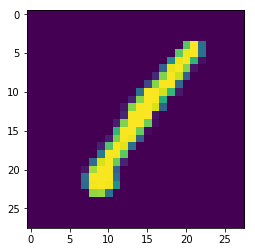

In [49]:
X2 = get_features(train_raw)
plt.imshow(np.reshape(X2[0,:],(int(np.sqrt(X2.shape[1])),int(np.sqrt(X2.shape[1])))))

According to my question at [Cross Validated](https://stats.stackexchange.com/questions/328817/vectorization-of-a-convolution-layer)  I need to build a transformation matrix $\mathcal{M}_k$ that would:

1. translate a group of pixels to the beginning of the image
1. crop the rest of the image 

for the sake of testing, let us define $\mathcal{M}_k \in \mathbb{R}^{25 \times n}$ to simulate a $5 \times 5$ patch 

## Question from Stack Exchange 

Excuse my primitive knowledge. I am trying to hand-make a Deep Neural Net library, and managed somehow to define all conventional fully connected layers, with all bells and whistles related to optimizations and speedups. 

Now comes to the Computer Vision part, where I want to ingest a large image into small patches and feeding it into a convolution, filter layer.

Of course easiest way to implement this is through a for loop by:

1. re-wrap image vector into a matrix or a tensor 
1. pad the image on all 4 sides
1. loop over x and y with strides and take out patches as a sub matrix 
1. pass that matrix to a pooling layer

but that sounds a bit tedious and time consuming.

so I was thinking of vectorizing this operation to take out all patches from the vector image once using some sort of a transformation matrix, but the math is a little bit challenging. 

I was thinking of some mapping function $\mathcal{M}_k : \vec{Im} \mapsto \mathbf{P}_k$ 

where $\mathbf{P}_k \in \mathbb{R}^{s_x \cdot s_y}$ is the $k$th patch vectorized and $$ \mathbf{P} = \large [ \mathbf{P}_1 \mathbf{P}_1 \dots \mathbf{P}_k \large ] $$ an array of equally sized $k$ vectorized patches 

So $\mathcal{M}_k$ be somehow a translation matrix, copying pixels of the current patch in in the first $s_x \cdot s_y$ positions of my output, and cropping the rest of the vector

#### Example 
A $100 \times 100 \times 1$ image tensor is vectorized into a 10'000 dimensional vector, assuming no padding and a first patch that is say $3 \times 3$ pixels we want to move pixels $ \{ 1, 2, 3, 101, 102, 103, 201, 202, 203\}$ into $\mathbf{P}_1$

So I would imagine $\mathcal{M}_1 \in \mathbb{R}^{9 \times 100'000}$ be something like this 

$$ \mathcal{M}_1 = 
\begin{pmatrix}
         1 & 0 & 0 & \dots 0 & 0 & 0 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 1 & 0 & \dots 0 & 0 & 0 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 0 & 1 & \dots 0 & 0 & 0 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 1 & 0 & 0 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 0 & 1 & 0 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 0 & 0 & 1 & \dots 0 & 0 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 0 & 0 & 0 & \dots 1 & 0 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 0 & 0 & 0 & \dots 0 & 1 & 0 & \dots & 0 \\
         0 & 0 & 0 & \dots 0 & 0 & 0 & \dots 0 & 0 & 1 & \dots & 0 \\
\end{pmatrix}
$$

_note that first group of columns is at positions 1 to 3, second group is 101 to 103, and third is 201 to 203_

Ok, now we have $\mathcal{M}_1 \cdot \mathbf{Im} = \mathbf{P}_1 \in \mathbb{R}^{9 \times 1}$ 

this somehow makes sense on how to translate and crop pixels from the input image for the first patch.

### My question is:

1. How to generalize a formula to construct $\mathcal{M}_{(c_x, c_y, s_x, s_y)}$; a mapping function taking patch centered at $(c_x, c_y)$ with dimensions $s_x$ and $s_y$
2. How to stack all mapping functions $\mathcal{M}_1$ all the way to $\mathcal{M}_k$ with input image $Im$ or some tensor made of $Im$ copies to avoid looping $k$ times to construct $\mathbf{P}$

Thanks 

In [63]:
sx = 5
sy = 5
cx = 0
cy = 0
stride_x = 3
stride_y = 3

orig_x_size = int(np.sqrt(X2.shape[1]))
orig_y_size = orig_x_size
M = np.zeros((X2.shape[1], (orig_x_size-sx)*(orig_y_size-sy)*sx*sy))
p_vec = 0
for cx in range(0, orig_x_size-sx, stride_x):
    for cy in range(0, orig_y_size-sy, stride_y):
        #
        #
        for px in range(sx):
            for py in range(sy):
                M[cx + px + (py+cy) * orig_x_size, p_vec] = 1
                p_vec += 1
        print("Processing: x:{}/{}, y:{}/{}".format(cx,orig_x_size-sx,cy,orig_y_size-sy))
P = np.dot(X2,M)       
#        P = np.concatenate((P, P_temp), axis = 1)
print(P.shape)

Processing: x:0/23, y:0/23
Processing: x:0/23, y:3/23
Processing: x:0/23, y:6/23
Processing: x:0/23, y:9/23
Processing: x:0/23, y:12/23
Processing: x:0/23, y:15/23
Processing: x:0/23, y:18/23
Processing: x:0/23, y:21/23
Processing: x:3/23, y:0/23
Processing: x:3/23, y:3/23
Processing: x:3/23, y:6/23
Processing: x:3/23, y:9/23
Processing: x:3/23, y:12/23
Processing: x:3/23, y:15/23
Processing: x:3/23, y:18/23
Processing: x:3/23, y:21/23
Processing: x:6/23, y:0/23
Processing: x:6/23, y:3/23
Processing: x:6/23, y:6/23
Processing: x:6/23, y:9/23
Processing: x:6/23, y:12/23
Processing: x:6/23, y:15/23
Processing: x:6/23, y:18/23
Processing: x:6/23, y:21/23
Processing: x:9/23, y:0/23
Processing: x:9/23, y:3/23
Processing: x:9/23, y:6/23
Processing: x:9/23, y:9/23
Processing: x:9/23, y:12/23
Processing: x:9/23, y:15/23
Processing: x:9/23, y:18/23
Processing: x:9/23, y:21/23
Processing: x:12/23, y:0/23
Processing: x:12/23, y:3/23
Processing: x:12/23, y:6/23
Processing: x:12/23, y:9/23
Processi

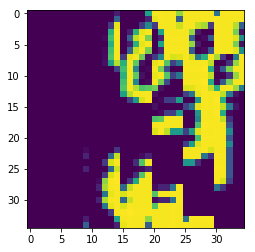

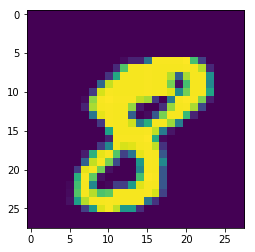

In [64]:
m_p, n_p = P.shape
one_side = int(np.sqrt(n_p))
slider = 0
block_size = sx * sy
p_idx = 10
show_case = np.reshape(P[p_idx,slider:slider+block_size],(sx, sy))

random_filter = np.random.randn(sx*sy,1)

line = np.zeros((sy,1))
for ix in range(0, int((orig_x_size-sx)/stride_x)):
#for ix in range(0, int((orig_x_size-sx))):    
    #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
    line = np.concatenate((line, np.reshape(P[p_idx,slider:slider+block_size],(sx, sy))), axis = 1)        
    slider += block_size
show_case = line[:,1:] 
for iy in range(1, int((orig_y_size-sy)/stride_y)):
#for iy in range(1, int((orig_y_size-sy))):
    line = np.zeros((sx,1))
    for ix in range(0, int((orig_x_size-sx)/stride_x)):    
    #for ix in range(0, int((orig_x_size-sx))):    
        #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
        line = np.concatenate((line, np.reshape(P[p_idx,slider:slider+block_size],(sx, sy))), axis = 1)        
        slider += block_size
    show_case = np.concatenate((show_case, line[:,1:]), axis = 0 )
plt.imshow(show_case.T)
plt.show()
plt.imshow(np.reshape(X2[p_idx,:],(int(np.sqrt(X2.shape[1])),int(np.sqrt(X2.shape[1])))))
plt.show()

Now I need to hook a filter and pooling layer to generate a set of scaled down images of my original input image 
according to my understanding, filter layer uses a kernel $\kappa_o$ against each patch $P_k$ to decide how far is this patch from that filer

so I would assume that this is some sort of a dot product $\langle\ P_k, \kappa_o \rangle$

also, to ensure that the filtered image is a lower resolution one, strides must be greater than 1

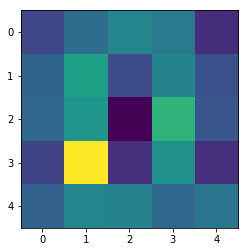

(1, 7)


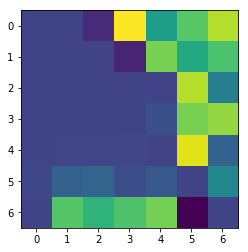

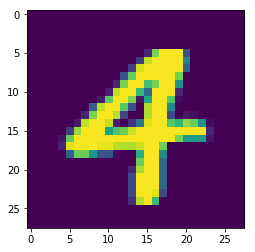

In [77]:
m_p, n_p = P.shape
one_side = int(np.sqrt(n_p))
slider = 0
block_size = sx * sy
p_idx = np.random.randint(0,1000)
show_case = np.reshape(P[p_idx,slider:slider+block_size],(sx, sy))

real_filter = np.random.randn(sx,sy)
plt.imshow(real_filter)
plt.show()
random_filter = np.reshape(real_filter, (-1,1))

line = np.zeros((1,1))
for ix in range(0, int((orig_x_size-sx)/stride_x)):
#for ix in range(0, int((orig_x_size-sx))):    
    #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
    line = np.concatenate((line, np.dot(np.reshape(P[p_idx,slider:slider+block_size],(1,-1)),random_filter)), axis = 1)        
    slider += block_size
show_case = line[:,1:] 

print(show_case.shape)
for iy in range(1, int((orig_y_size-sy)/stride_y)):
#for iy in range(1, int((orig_y_size-sy))):
    line = np.zeros((1,1))
    for ix in range(0, int((orig_x_size-sx)/stride_x)):    
    #for ix in range(0, int((orig_x_size-sx))):    
        #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
        line = np.concatenate((line, np.dot(np.reshape(P[p_idx,slider:slider+block_size],(1,-1)),random_filter)), axis = 1)        
        slider += block_size
    show_case = np.concatenate((show_case, line[:,1:]), axis = 0 )
plt.imshow(show_case.T)
plt.show()
plt.imshow(np.reshape(X2[p_idx,:],(int(np.sqrt(X2.shape[1])),int(np.sqrt(X2.shape[1])))))
plt.show()